In [1]:
import uproot
from pathlib import Path
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import hist
import mplhep as hep

## Stitching ZZ signal (incl. & LHE_VPT filter)

In [2]:
year="2018"

In [ ]:
def load_dir(d_list):
    if isinstance(d_list, str): d_list = [d_list]
    event_count = 0.
    event_count_VpTGt200 = 0
    sum_genw = 0.
    sum_genw_VpTGt200 = 0.
    for d in d_list:
        for path in Path(d).glob('*.root'):
            if "_up" in path.name or "_down" in path.name: continue
            with uproot.open(str(path)) as f:
                #h = f["sum_genw"]
                #sum_genw += h.values()[0]
                #event_count += h.all_members["fEntries"]

                ar = f["Events"].arrays(filter_name=["LHE_Vpt", "genWeightFixed"])

                sum_genw += np.sum(ar.genWeightFixed)
                event_count += len(ar.genWeightFixed)
                sum_genw_VpTGt200 += np.sum(np.where(ar["LHE_Vpt"]>200, ar.genWeightFixed, 0.))
                event_count_VpTGt200 += np.count_nonzero(ar["LHE_Vpt"]>200)
    return {"total_events": event_count, "total_sum_genw":sum_genw, "sum_genw_VpTGt200":sum_genw_VpTGt200, "event_count_VpTGt200":event_count_VpTGt200}
def full_load_dir(d_list):
    if isinstance(d_list, str): d_list = [d_list]
    ars = []
    for d in d_list:
        for path in Path(d).glob('*.root'):
            if "_up" in path.name or "_down" in path.name: continue
            with uproot.open(str(path)) as f:
                ars.append(f["Events"].arrays(filter_name=["LHE_Vpt", "genWeightFixed"]))
    return ak.concatenate(ars)
def weightToUnity(ar): # weight to unity is also equal to : genWeight / avg(genWeight) = genWeight * nevts / sum(genWeight)
    return np.where(ar>0, 1., -1.)

In [27]:
# computing sticthing weights for ZZ 2018
res_inclusive = load_dir([f"/grid_mnt/data__data.polcms/cms/cuisset/cmt/PreprocessRDF/bul_{year}_ZZ_v12/zz_sl_signal/cat_base_selection/prod_250315",
          f"/grid_mnt/data__data.polcms/cms/cuisset/cmt/PreprocessRDF/bul_{year}_ZZ_v12/zz_bbtt_dnnTraining/cat_base_selection/prod_250315"])
res_filter = load_dir([f"/grid_mnt/data__data.polcms/cms/cuisset/cmt/PreprocessRDF/bul_{year}_ZZ_v12/zz_bbtt_vptFilter_dnnTraining/cat_base_selection/prod_250315"])
res_inclusive, res_filter

({'total_events': 139532.0,
  'total_sum_genw': 698657.0951538086,
  'sum_genw_VpTGt200': 51163.9754396081,
  'event_count_VpTGt200': 12568},
 {'total_events': 9158.0,
  'total_sum_genw': 1367.1551513671875,
  'sum_genw_VpTGt200': 1367.0957214832306,
  'event_count_VpTGt200': 9158})

In [28]:
ar_incl = full_load_dir([f"/grid_mnt/data__data.polcms/cms/cuisset/cmt/PreprocessRDF/bul_{year}_ZZ_v12/zz_sl_signal/cat_base_selection/prod_250315",
          f"/grid_mnt/data__data.polcms/cms/cuisset/cmt/PreprocessRDF/bul_{year}_ZZ_v12/zz_bbtt_dnnTraining/cat_base_selection/prod_250315"])
ar_filter = full_load_dir([f"/grid_mnt/data__data.polcms/cms/cuisset/cmt/PreprocessRDF/bul_{year}_ZZ_v12/zz_bbtt_vptFilter_dnnTraining/cat_base_selection/prod_250315"])

In [29]:
# selection effieicncy is :
res_inclusive["sum_genw_VpTGt200"]/res_inclusive["total_sum_genw"] # = eff = sigma(VpT) / sigma(incl)

0.07323188413100479

In [30]:
# set the gen weight to
# LHE_VpT<200 : +-1 * sigma(incl)
# LHE_VpT>200 : +- 1 * sigma(VpT>200) / (N_VpT + eff*N_incl) = +- 1 * sigma(incl) / (N_incl + N_VpT/eff)

In [ ]:

stitchWeight = 1. / (np.sum(weightToUnity(ar_incl.genWeightFixed)) + np.sum(weightToUnity(ar_filter.genWeightFixed))/(res_inclusive["sum_genw_VpTGt200"]/res_inclusive["total_sum_genw"]))
stitchWeight # stitch weight for VpT>200

6.867737048184594e-06

In [32]:
np.sum(weightToUnity(ar_filter.genWeightFixed))/(res_inclusive["sum_genw_VpTGt200"]/res_inclusive["total_sum_genw"]), np.sum(weightToUnity(ar_incl.genWeightFixed))

(61776.370411377095, 83832.0)

In [33]:
1/(np.sum(weightToUnity(ar_filter.genWeightFixed))/(res_inclusive["sum_genw_VpTGt200"]/res_inclusive["total_sum_genw"]))

1.618741912710097e-05

In [34]:
1./np.sum(weightToUnity(ar_incl.genWeightFixed)) # stitch for VpT<200

1.1928619143048001e-05

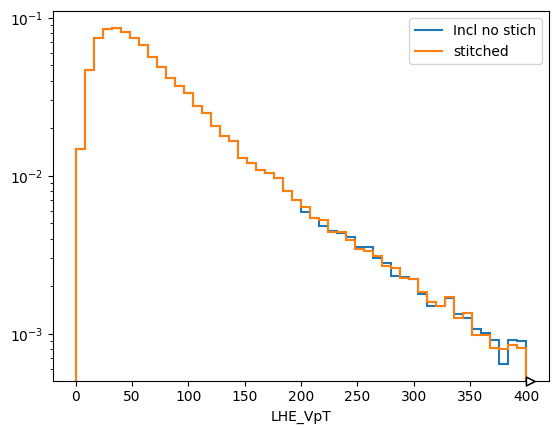

In [35]:
hep.histplot(hist.new.Regular(50, 0., 400, name="LHE_VpT").Weight().fill(ar_incl.LHE_Vpt, weight=weightToUnity(ar_incl.genWeightFixed)/np.sum(weightToUnity(ar_incl.genWeightFixed))), yerr=False, label="Incl no stich")
hep.histplot(
    hist.new.Regular(50, 0., 400, name="LHE_VpT").Weight()
    .fill(ar_incl.LHE_Vpt, weight=weightToUnity(ar_incl.genWeightFixed)*np.where(ar_incl.LHE_Vpt<200, 1./np.sum(weightToUnity(ar_incl.genWeightFixed)), stitchWeight))
    .fill(ar_filter.LHE_Vpt, weight=stitchWeight*weightToUnity(ar_filter.genWeightFixed))
, yerr=False, label="stitched")
plt.yscale("log")
plt.legend()

## stitching ZbbHtt

In [61]:
def load_dir_ZbbHtt(d_list):
    if isinstance(d_list, str): d_list = [d_list]
    event_count = 0.
    event_count_VpTGt200 = 0
    sum_genw = 0.
    sum_genw_VpTGt200 = 0.
    ars = []
    for d in d_list:
        for path in Path(d).glob('*.root'):
            if "_up" in path.name or "_down" in path.name: continue
            with uproot.open(str(path)) as f:
                #h = f["sum_genw"]
                #sum_genw += h.values()[0]
                #event_count += h.all_members["fEntries"]

                ar = f["Events"].arrays(filter_name=["genWeightFixed", "LHEPart_*", "LHE_Vpt", "genXtautau_pt", "genXbb_pt"], how="zip")
                # return ar
                Z_pt = ak.firsts(ar.LHEPart[(ar.LHEPart.status==2)&(ar.LHEPart.pdgId == 23)]).pt
                H_pt = ak.firsts(ar.LHEPart[(ar.LHEPart.status==1)&(ar.LHEPart.pdgId == 25)]).pt
                VpTGt200 = (Z_pt > 200) & (H_pt > 200)

                sum_genw += np.sum(ar.genWeightFixed)
                event_count += len(ar.genWeightFixed)
                sum_genw_VpTGt200 += np.sum(np.where(VpTGt200, ar.genWeightFixed, 0.))
                event_count_VpTGt200 += np.count_nonzero(VpTGt200)
                ars.append(ak.zip({"genWeightFixed":ar["genWeightFixed"], "maxVpT": ak.where(Z_pt>H_pt, Z_pt, H_pt), "Z_pt":Z_pt, "H_pt":H_pt, "LHE_Vpt":ar["LHE_Vpt"]}))
    return {"total_events": event_count, "total_sum_genw":sum_genw, "sum_genw_VpTGt200":sum_genw_VpTGt200, "event_count_VpTGt200":event_count_VpTGt200, "ar":ak.concatenate(ars)} 
def weightToUnity(ar): # weight to unity is also equal to : genWeight / avg(genWeight) = genWeight * nevts / sum(genWeight)
    return np.where(ar>0, 1., -1.)

In [62]:
# ZbbHtt is made wi
res_inclusive = load_dir_ZbbHtt([f"/grid_mnt/data__data.polcms/cms/cuisset/cmt/PreprocessRDF/bul_{year}_ZbbHtt_v12/zh_zbb_htt_signal/cat_base_selection/prod_250315",
          f"/grid_mnt/data__data.polcms/cms/cuisset/cmt/PreprocessRDF/bul_{year}_ZbbHtt_v12/zh_zbb_htt_dnnTraining/cat_base_selection/prod_250315"])
res_filter = load_dir_ZbbHtt([f"/grid_mnt/data__data.polcms/cms/cuisset/cmt/PreprocessRDF/bul_{year}_ZbbHtt_v12/zh_zbb_htt_vptFilter_dnnTraining/cat_base_selection/prod_250315"])

In [39]:
1./np.sum(weightToUnity(res_inclusive["ar"].genWeightFixed)) # stitch for VpT<200

8.43397881384522e-06

In [40]:

stitchWeight = 1. / (np.sum(weightToUnity(res_inclusive["ar"].genWeightFixed)) + np.sum(weightToUnity(res_filter["ar"].genWeightFixed))/(res_inclusive["sum_genw_VpTGt200"]/res_inclusive["total_sum_genw"]))
stitchWeight # stitch weight for VpT>200

3.688162707942288e-06

In [64]:
res_inclusive["ar"]

<Array [{genWeightFixed: 0.838, ...}, ...] type='233588 * {genWeightFixed: ...'>

In [52]:
year="2018"

## Stitching ZttHbb

In [59]:
res_inclusive = load_dir_ZbbHtt([f"/grid_mnt/data__data.polcms/cms/cuisset/cmt/PreprocessRDF/bul_{year}_ZttHbb_v12/zh_ztt_hbb_signal/cat_base_selection/prod_250315",
          f"/grid_mnt/data__data.polcms/cms/cuisset/cmt/PreprocessRDF/bul_{year}_ZttHbb_v12/zh_ztt_hbb_dnnTraining/cat_base_selection/prod_250315"])
res_filter = load_dir_ZbbHtt([f"/grid_mnt/data__data.polcms/cms/cuisset/cmt/PreprocessRDF/bul_{year}_ZttHbb_v12/zh_ztt_hbb_vptFilter_dnnTraining/cat_base_selection/prod_250315"])

In [54]:
1./np.sum(weightToUnity(res_inclusive["ar"].genWeightFixed)) # stitch for VpT<200

2.0376558806748714e-06

In [55]:

stitchWeight = 1. / (np.sum(weightToUnity(res_inclusive["ar"].genWeightFixed)) + np.sum(weightToUnity(res_filter["ar"].genWeightFixed))/(res_inclusive["sum_genw_VpTGt200"]/res_inclusive["total_sum_genw"]))
stitchWeight # stitch weight for VpT>200

1.6688810910754723e-06

In [60]:
res_inclusive["ar"]["LHE_Vpt"]

<Array [134, 130, 505, 197, ..., 125, 221, 76.2, 91.4] type='513224 * float32'>

## Stitching DY 

In [41]:
dy_nevents = {}
for year in ["2018", "2017", "2016", "2016_HIPM"]:
    for dataset in ["dy"] + [f"dy_ptz{i}" for i in range(1, 6+1)] + ["dy_0j", "dy_1j", "dy_2j"]:
        with uproot.open(f"/grid_mnt/data__data.polcms/cms/cuisset/cmt/MergeCategorization/bul_{year}_ZZ_v12/{dataset}/cat_baseline_resolved_nobtag/prod_250315/data_0.root") as f:
            entries = int(f["sum_genw"].all_members["fEntries"])
            dy_nevents.setdefault(year, dict())[dataset] = entries
            print(dataset, entries)
dy_nevents

dy 196946491
dy_ptz1 198214727
dy_ptz2 120643424
dy_ptz3 56500410
dy_ptz4 23068060
dy_ptz5 3456081
dy_ptz6 3593052
dy_0j 85742913
dy_1j 87574150
dy_2j 42098601
dy 194921357
dy_ptz1 197757001
dy_ptz2 122866909
dy_ptz3 80534990
dy_ptz4 24219168
dy_ptz5 3991030
dy_ptz6 4034670
dy_0j 78448070
dy_1j 84402280
dy_2j 47006742
dy 72700452
dy_ptz1 100053291
dy_ptz2 59751869
dy_ptz3 38443702
dy_ptz4 12298946
dy_ptz5 1980401
dy_ptz6 2018613
dy_0j 76450315
dy_1j 81862201
dy_2j 41249758
dy 90827009
dy_ptz1 101195882
dy_ptz2 60848787
dy_ptz3 39968289
dy_ptz4 12024545
dy_ptz5 1924211
dy_ptz6 1999583
dy_0j 79522471
dy_1j 88364975
dy_2j 42503191


{'2018': {'dy': 196946491,
  'dy_ptz1': 198214727,
  'dy_ptz2': 120643424,
  'dy_ptz3': 56500410,
  'dy_ptz4': 23068060,
  'dy_ptz5': 3456081,
  'dy_ptz6': 3593052,
  'dy_0j': 85742913,
  'dy_1j': 87574150,
  'dy_2j': 42098601},
 '2017': {'dy': 194921357,
  'dy_ptz1': 197757001,
  'dy_ptz2': 122866909,
  'dy_ptz3': 80534990,
  'dy_ptz4': 24219168,
  'dy_ptz5': 3991030,
  'dy_ptz6': 4034670,
  'dy_0j': 78448070,
  'dy_1j': 84402280,
  'dy_2j': 47006742},
 '2016': {'dy': 72700452,
  'dy_ptz1': 100053291,
  'dy_ptz2': 59751869,
  'dy_ptz3': 38443702,
  'dy_ptz4': 12298946,
  'dy_ptz5': 1980401,
  'dy_ptz6': 2018613,
  'dy_0j': 76450315,
  'dy_1j': 81862201,
  'dy_2j': 41249758},
 '2016_HIPM': {'dy': 90827009,
  'dy_ptz1': 101195882,
  'dy_ptz2': 60848787,
  'dy_ptz3': 39968289,
  'dy_ptz4': 12024545,
  'dy_ptz5': 1924211,
  'dy_ptz6': 1999583,
  'dy_0j': 79522471,
  'dy_1j': 88364975,
  'dy_2j': 42503191}}